# Loading Data and Libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="pandas only supports SQLAlchemy")
import pyodbc

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


In [3]:
# Define the connection parameters
server = 'Darkred69'  # e.g., 'localhost' or '127.0.0.1'
database = 'CompanyX'  # Database name
username = 'DARKRED69\luan1'  # SQL Server username
password = '123456'  # SQL Server password

conn = pyodbc.connect(
    f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes'
)

# Query the table
query = "SELECT * FROM Fact_table"
df_fact = pd.read_sql(query, conn)

query = "SELECT * FROM Dim_Location"
df_location = pd.read_sql(query, conn)

query = "SELECT * FROM Dim_Product"
df_Product = pd.read_sql(query, conn)

query = "SELECT * FROM Dim_Customer"
df_Customer= pd.read_sql(query, conn)

query = "SELECT * FROM Dim_Promotion"
df_Promotion= pd.read_sql(query, conn)

query = "SELECT * FROM Dim_Date"
df_Date= pd.read_sql(query, conn)

df = df_fact.merge(df_location, on='Territory_key', how='left')\
            .merge(df_Product, on='Product_key', how='left')\
            .merge(df_Customer, on='Customer_key', how='left')\
            .merge(df_Promotion, on='Promotion_key', how='left')\
            .merge(df_Date, on='Date_key', how='left')

# Drop duplicate columns (e.g., ModifiedDate_x and ModifiedDate_y)
df = df.loc[:, ~df.columns.duplicated()]


# Display the resulting DataFrame
print(df.head())

# Close the connection
conn.close()

C:\Users\luan1\AppData\Local\Temp\ipykernel_5636\1144382779.py:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'ModifiedDate_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = df_fact.merge(df_location, on='Territory_key', how='left')\
C:\Users\luan1\AppData\Local\Temp\ipykernel_5636\1144382779.py:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'ModifiedDate_x'} in the result is deprecated and will raise a MergeError in a future version.
  df = df_fact.merge(df_location, on='Territory_key', how='left')\


   Fact_key  SalesOrderID  Territory_key  Customer_key  Promotion_key  \
0         1         47006             10           421              5   
1         2         62654              8         14156              5   
2         3         57086              7           303              5   
3         4         48735              3           344              5   
4         5         58358             10         18756              5   

   Product_key  Date_key  LineTotal  Discount_Percentage  OrderQty  ...  \
0          193       135    33.7745                  0.0       1.0  ...   
1          286       213   159.0000                  0.0       1.0  ...   
2           70       323  6884.9700                  0.0       5.0  ...   
3            2        38  3758.3520                  0.0       8.0  ...   
4          292       860    34.9900                  0.0       1.0  ...   

  SpecialOfferID       Name_y         Type     Category Duration     DateID  \
0              1  No Discount  

# Data Preprocessing for Model

In [4]:
df.isnull().sum()
# We can see that these nulls occurs all in the same day, therefore we can assume this is a bug in the system when 
# the customer was placing orders, therefore we will remove these
null_rows = df[df.isnull().any(axis=1)]
# Remove Null Values
df = df.dropna()

In [5]:
# Dropping all the keys and IDs
columns_to_drop = [col for col in df.columns if "ID" in col or "key" in col or "ModifiedDate" in col]
df = df.drop(columns=columns_to_drop)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121302 entries, 0 to 121316
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   LineTotal            121302 non-null  float64
 1   Discount_Percentage  121302 non-null  float64
 2   OrderQty             121302 non-null  float64
 3   Country              121302 non-null  object 
 4   Territory            121302 non-null  object 
 5   ProductCategoryName  121302 non-null  object 
 6   SubCategoryName      121302 non-null  object 
 7   Name_x               121302 non-null  object 
 8   ProductNumber        121302 non-null  object 
 9   StandardCost         121302 non-null  float64
 10  ListPrice            121302 non-null  float64
 11  FirstName            121302 non-null  object 
 12  LastName             121302 non-null  object 
 13  FullName             121302 non-null  object 
 14  EmailPromotion       121302 non-null  int64  
 15  Name_y           

In [7]:
# These columns are dropped because they are considerd as Names or Identifications or they are a replica of an exsting category
df.drop(["Name_x","Country","ProductCategoryName","ProductNumber","FirstName","LastName","FullName","Name_y"],axis = 1, inplace =True)

In [8]:
# Encoded Data for Non-Ordinal
df = pd.get_dummies(df, columns=['Territory', 
                                 'SubCategoryName', 
                                  'Type', 'Category', 'Day_of_week', 
                                 'Month'], drop_first=True)


# Ridge Regression

In [9]:
from sklearn.feature_selection import f_regression

# Example target column
target = df["Discount_Percentage"]

# Feature importance scores
f_scores, p_values = f_regression(df, target)

# Create a DataFrame for feature scores
feature_scores = pd.DataFrame({'Feature': df.columns, 'F-Score': f_scores, 'P-Value': p_values})

feature_scores.sort_values(by="F-Score", ascending=False).head(11)

,Feature,F-Score,P-Value
1,Discount_Percentage,6.069851e+19,0.0
6,Duration,4.154320e+05,0.0
52,Type_Discount,6.749070e+04,0.0
59,Category_Seasonal,6.749070e+04,0.0
55,Type_No Discount,4.641380e+04,0.0
54,Type_New Product,4.067541e+04,0.0
58,Category_Reseller,2.667754e+04,0.0
53,Type_Excess Inventory,9.435681e+03,0.0
56,Type_Seasonal Discount,4.437862e+03,0.0
2,OrderQty,3.560266e+03,0.0


In [10]:
# Choosing the 8 highest Features
top_features_Ridge = feature_scores.sort_values(by="F-Score", ascending=False).head(11)["Feature"].iloc[1:]
X = df[top_features_Ridge]
y = df['Discount_Percentage']
# Split the data into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Stadardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Train Ridge Regression
ridge_model = Ridge(alpha=1.0)  # Regularization strength alpha=1.0
ridge_model.fit(X_train_scaled, y_train)

# Predict
ridge_preds = ridge_model.predict(X_test_scaled)

# Evaluate
print("Ridge Regression Performance:")
print("MAE:", mean_absolute_error(y_test, ridge_preds))
print("MSE:", mean_squared_error(y_test, ridge_preds))
print("R2 Score:", r2_score(y_test, ridge_preds))

Ridge Regression Performance:
MAE: 0.0018312093303523207
MSE: 2.26669306948112e-05
R2 Score: 0.9602661112279103


In [12]:
# Check for overfitting or not
# Predictions
y_train_pred = ridge_model.predict(X_train_scaled)
y_test_pred = ridge_model.predict(X_test_scaled)

# Evaluate performance
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Output results
print("Training Set Performance:")
print(f"Mean Squared Error: {train_mse:}")
print(f"R-squared: {train_r2:}\n")

print("Test Set Performance:")
print(f"Mean Squared Error: {test_mse:}")
print(f"R-squared: {test_r2:}\n")

# Check for overfitting
if train_r2 - test_r2 > 0.1:  # Adjust the threshold as needed
    print("The model might be overfitting. Consider increasing regularization or gathering more data.")
else:
    print("The model does not appear to be overfitting.")

Training Set Performance:
Mean Squared Error: 2.122157106261766e-05
R-squared: 0.9661495205266049

Test Set Performance:
Mean Squared Error: 2.26669306948112e-05
R-squared: 0.9602661112279103

The model does not appear to be overfitting.


# Decision Tree Regressor

In [13]:
# Feature and target selection
X = df.drop(columns=['Discount_Percentage'])  # Exclude target column
y = df['Discount_Percentage']  # Target column

# Scale the features if needed (especially for regression tasks)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [14]:
# Train a Decision Tree Regressor
tree_regressor = DecisionTreeRegressor(random_state=42)
tree_regressor.fit(X_scaled, y)

# Get feature importance
feature_importance = tree_regressor.feature_importances_

# Create a DataFrame to view features and their importance scores
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(10))  # Top 10 important features


                           Feature  Importance
5                         Duration    0.773579
36  SubCategoryName_Mountain Bikes    0.147961
1                         OrderQty    0.038256
40      SubCategoryName_Road Bikes    0.016861
2                     StandardCost    0.006201
65                    Month_August    0.005238
3                        ListPrice    0.002533
63             Day_of_week_Tuesday    0.002477
7                             Year    0.002295
60            Day_of_week_Saturday    0.001626


In [15]:
# Select the top N features (e.g., top 10 most important)
top_n = 10
top_features_DTR = importance_df.head(top_n)['Feature']

# Create a new dataset with only top features
X_top_features = X[top_features_DTR]

# Train a new model with only the selected top features
X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size=0.2, random_state=42)
tree_regressor.fit(X_train, y_train)

# Evaluate the model
y_pred = tree_regressor.predict(X_test)

# Evaluate
print("Decision Tree Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


Decision Tree Performance:
MAE: 1.4700902503684146e-05
MSE: 1.0948591972617343e-07
R2 Score: 0.9998080771757287


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate the model on the training set
y_train_pred = tree_regressor.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluate the model on the test set
y_test_pred = tree_regressor.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print performance metrics
print("Training Set Performance:")
print(f"MAE: {train_mae:}")
print(f"MSE: {train_mse:}")
print(f"R2 Score: {train_r2:}\n")

print("Test Set Performance:")
print(f"MAE: {test_mae:}")
print(f"MSE: {test_mse:}")
print(f"R2 Score: {test_r2:}\n")

# Check for overfitting
if train_r2 - test_r2 > 0.1:  # Adjust threshold based on use case
    print("The model might be overfitting. Consider pruning the tree or adjusting hyperparameters.")
else:
    print("The model does not appear to be overfitting.")


Training Set Performance:
MAE: 2.66134115827828e-05
MSE: 2.2894341750030926e-06
R2 Score: 0.9963481287828333

Test Set Performance:
MAE: 1.4700902503684146e-05
MSE: 1.0948591972617343e-07
R2 Score: 0.9998080771757287

The model does not appear to be overfitting.


# Gradient Boosting Regressor

In [17]:
# Feature and target selection
X = df.drop(columns=['Discount_Percentage'])  # Exclude target column
y = df['Discount_Percentage']  # Target column

# Scale the features if needed (especially for regression tasks)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [18]:
# Train a GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X, y)

# Get feature importance
feature_importance = gb_regressor.feature_importances_

# Create a DataFrame to view features and their importance scores
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Print the top 10 important features
print(importance_df.head(10))  # Top 10 important features


                           Feature  Importance
5                         Duration    0.776634
36  SubCategoryName_Mountain Bikes    0.146406
1                         OrderQty    0.038351
2                     StandardCost    0.008110
40      SubCategoryName_Road Bikes    0.006692
52           Type_Excess Inventory    0.005025
3                        ListPrice    0.004791
65                    Month_August    0.004684
63             Day_of_week_Tuesday    0.002373
0                        LineTotal    0.001165


In [19]:
# Select the top N features (e.g., top 10 most important)
top_n = 10
top_features_GBR = importance_df.head(top_n)['Feature']

# Create a new dataset with only top features
X_top_features = X[top_features_GBR]

# Train a new model with only the selected top features
X_train, X_test, y_train, y_test = train_test_split(X_top_features, y, test_size=0.2, random_state=42)
gb_regressor.fit(X_train, y_train)

# Evaluate the model
y_pred = gb_regressor.predict(X_test)
# Evaluate
print("Gradient Boosting Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))



Gradient Boosting Performance:
MAE: 6.852443907280716e-05
MSE: 9.492017519209097e-07
R2 Score: 0.9983361012860144


In [20]:
# Evaluate on the training set
y_train_pred = gb_regressor.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluate on the test set
y_test_pred = gb_regressor.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print performance metrics
print("Training Set Performance:")
print(f"MAE: {train_mae:}")
print(f"MSE: {train_mse:}")
print(f"R2 Score: {train_r2:}\n")

print("Test Set Performance:")
print(f"MAE: {test_mae:}")
print(f"MSE: {test_mse:}")
print(f"R2 Score: {test_r2:}\n")

# Check for overfitting
if train_r2 - test_r2 > 0.1:  # Adjust threshold as needed
    print("The model might be overfitting. Consider adjusting hyperparameters or using early stopping.")
else:
    print("The model does not appear to be overfitting.")

Training Set Performance:
MAE: 7.69365525324922e-05
MSE: 3.1269134311297834e-06
R2 Score: 0.9950122675364975

Test Set Performance:
MAE: 6.852443907280716e-05
MSE: 9.492017519209097e-07
R2 Score: 0.9983361012860144

The model does not appear to be overfitting.


# Preparing for Visualization of 3 Models

In [21]:
# Get the last 360 values
df_filtered = df[-360:]

# Separate X and y features
X = df_filtered.drop(columns=['Discount_Percentage'])
y = df_filtered['Discount_Percentage']

# Separate the Xs for each model
X_Ridge = X[top_features_Ridge]
X_Ridge = scaler.fit_transform(X_Ridge)  # Ridge needs scaled data
X_DTR = X[top_features_DTR]
X_GBR = X[top_features_GBR]

# Create the Predictions
ridge_preds = ridge_model.predict(X_Ridge)
DTR_pred = tree_regressor.predict(X_DTR)
GBR_pred = gb_regressor.predict(X_GBR)

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y.values,  # Ensure y is aligned
    'Ridge_Predictions': ridge_preds,
    'DTR_Predictions': DTR_pred,
    'GBR_Predictions': GBR_pred
})

# Display the results DataFrame
print(results_df)


     Actual  Ridge_Predictions  DTR_Predictions  GBR_Predictions
0       0.0          -0.001199              0.0     5.367976e-08
1       0.0          -0.001199              0.0     5.367976e-08
2       0.0          -0.000036              0.0     1.640349e-07
3       0.0           0.002290              0.0     1.640349e-07
4       0.0          -0.001199              0.0     5.367976e-08
..      ...                ...              ...              ...
355     0.0           0.003705              0.0     7.474431e-07
356     0.0          -0.001199              0.0     5.367976e-08
357     0.0          -0.001199              0.0     7.474431e-07
358     0.0          -0.001194              0.0    -1.859378e-05
359     0.0           0.001127              0.0     8.577983e-07

[360 rows x 4 columns]


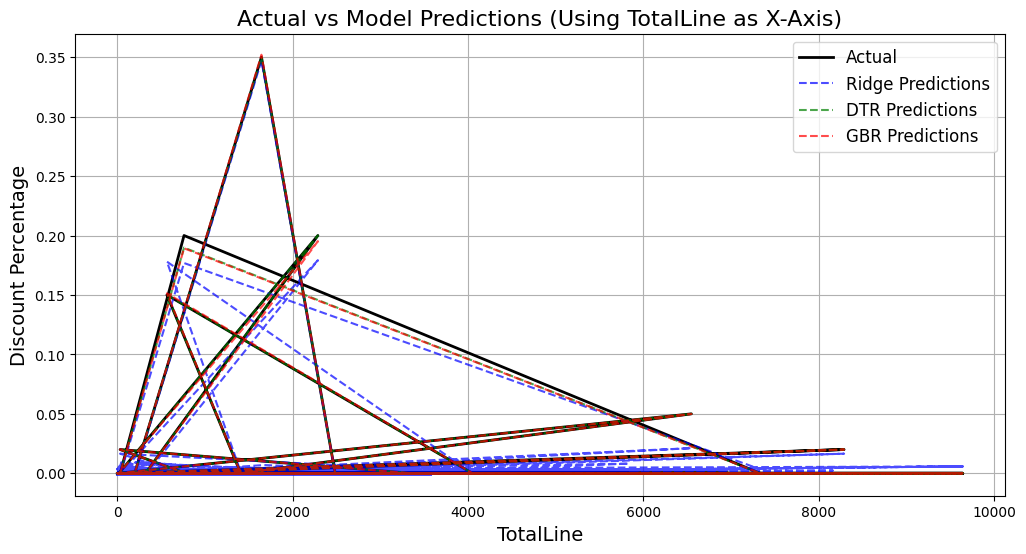

In [22]:
import matplotlib.pyplot as plt

# Create a plot for Actual vs Predictions with TotalLine as the x-axis
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(X["LineTotal"], results_df['Actual'], label='Actual', color='black', linewidth=2)

# Plot predictions from each model
plt.plot(X["LineTotal"], results_df['Ridge_Predictions'], label='Ridge Predictions', linestyle='--', color='blue', alpha=0.7)
plt.plot(X["LineTotal"], results_df['DTR_Predictions'], label='DTR Predictions', linestyle='--', color='green', alpha=0.7)
plt.plot(X["LineTotal"], results_df['GBR_Predictions'], label='GBR Predictions', linestyle='--', color='red', alpha=0.7)

# Add labels, title, and legend
plt.title('Actual vs Model Predictions (Using TotalLine as X-Axis)', fontsize=16)
plt.xlabel('TotalLine', fontsize=14)
plt.ylabel('Discount Percentage', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show the plot
plt.show()


In [35]:
# Connect to database
conn_str = ("mssql+pyodbc://@Darkred69/CompanyX?driver=ODBC+Driver+17+for+SQL+Server") #Change Darkred69 with server
engine = create_engine(conn_str)

# Insert DataFrame into SQL table
table_name = 'Dim_predict'
results_df.to_sql(table_name, con=engine,if_exists='replace', index=False)  # Replace table if it exists


360